In [96]:
# Standard library imports
import time
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from collections import Counter


# Set random seed for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [97]:
import os
os.listdir("../data") # Asks the OS: “What files/folders exist directly inside data/?”


['Face_mask_detection', 'Face_mask_detection.zip']

In [98]:
import zipfile
from pathlib import Path
import os

zip_path = Path("../data/Face_mask_detection.zip")
extract_dir = Path("../data/Face_mask_detection")

extract_dir.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

print("Extracted files:", os.listdir(extract_dir))

Extracted files: ['data']


In [99]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-4
epoch = 15
print_every = 5



In [100]:
#Data Loader 
# Some of your images are palette (“P”) mode PNGs with transparency.
#  PIL warns it wants them converted to RGBA. " transforms.Lambda(lambda img: img.convert("RGBA")),"

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGBA")),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)), # updated the size, because i got error to make this faster
    transforms.ToTensor(), # this line doing "torch.stack and torch.tensor"
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(  # knows where images are,knows labels, knows how to transform each image
    root="../data/Face_mask_detection/data",
    transform=transform
)



In [101]:
dataset.classes

['with_mask', 'without_mask']

In [102]:
num_class = len(dataset.classes)
print(num_class)

2


In [103]:
# creating training , validation and testing dataset
# 1. Set the seed, so i will get the same dataset every run
gen = torch.Generator().manual_seed(315)

n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test],
                                         generator=gen
                                         )


In [104]:
from collections import Counter

# Get all labels from the training subset
train_indices = train_ds.indices
# This assumes your original dataset has a .labels or .targets attribute
# If it's a ImageFolder, use dataset.targets
all_labels = [dataset.targets[i] for i in train_indices]

counts = Counter(all_labels)

# Calculate ratio
total = sum(counts.values())
for cls, count in counts.items():
    print(f"Class {cls}: {count/total*100:.2f}%")

Class 1: 51.39%
Class 0: 48.61%


In [105]:
from torch.utils.data import WeightedRandomSampler

# 1. Get weights for the entire training set
class_sample_count = [counts[0], counts[1]] # e.g., [100, 500]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
samples_weights = torch.tensor([weights[label] for label in all_labels])

# 2. Create the sampler
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

# 3. Update your DataLoader (Remove shuffle=True when using a sampler)
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler 
)

In [106]:
# data loader
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    # shuffle=True
    sampler=sampler
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size ,
    shuffle=False,
    
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=0 # While your GPU is training the current batch, these workers are already preparing the next batch
)


In [107]:
print("train:", len(train_loader.dataset))
print("val  :", len(val_loader.dataset))
print("test :", len(test_loader.dataset))


train: 5287
val  : 1132
test : 1134


In [108]:
print(dataset.classes)
print(dataset.class_to_idx)

['with_mask', 'without_mask']
{'with_mask': 0, 'without_mask': 1}


In [109]:
X_batch, y_batch = next(iter(train_loader))
print("X batch:(Batch of images)", X_batch.shape)
print("y batch:(the target labels)", y_batch.shape)

X batch:(Batch of images) torch.Size([32, 1, 128, 128])
y batch:(the target labels) torch.Size([32])


In [110]:
# defining the CCN model
model = nn.Sequential(
    # Block 1: Focuses on edges/textures
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # If input is 128, now it's 64

    # Block 2: Focuses on more complex shapes (nose, mouth, mask edges)
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # If input was 64, now it's 32

    # Global Pool: Condenses features before the classifier
    nn.AdaptiveAvgPool2d((4, 4)), 

    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2) # Raw logits for CrossEntropyLoss
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): AdaptiveAvgPool2d(output_size=(4, 4))
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2048, out_features=256, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Linear(in_features=256, out_features=2, bias=True)
)

Total parameters: 599938


In [111]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=learning_rate, # hyper paarmeter to 
                            weight_decay=1e-4
                            )

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 15,
    print_every: int = 1,
    best_val_loss = float('inf'),
    patience = 3,
    trigger_times = 0
    device: torch.device = None
)-> dict[str, list[float]]:
    '''Training loop for PyTorch classification model.
    
    Args:
        device: If provided, moves batches to this device on-the-fly.
                If None, assumes data is already on the correct device.
    '''

    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            
            # Move batch to device if specified
            if device is not None:
                images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():

            for images, labels in val_loader:
                
                # Move batch to device if specified
                if device is not None:
                    images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Record metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # 2. COMPARE AND UPDATE
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Record the new best score
            torch.save(model.state_dict(), 'best_model.pth') # Save the winner
            trigger_times = 0         # Reset the "strikes"
            print(f"Epoch {epoch}: New best model saved!")
        else:
            trigger_times += 1        # No improvement, add a strike
            print(f"Epoch {epoch}: No improvement. Strike {trigger_times}")

    # 3. THE KILL SWITCH
        if trigger_times >= patience:
            print("Stopping early to prevent overfitting.")
            break

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:

            print(
                f'Epoch {epoch+1}/{epochs} - ' +
                f'loss: {train_loss:.4f} - ' +
                f'accuracy: {train_accuracy:.2f}% - ' +
                f'val_loss: {val_loss:.4f} - ' +
                f'val_accuracy: {val_accuracy:.2f}%'
            )

    print('\nTraining complete.')

    return history

In [113]:
%%time

history_exp1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs= epoch,
    print_every=print_every
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 0: New best model saved!
Epoch 1/15 - loss: 0.5436 - accuracy: 72.63% - val_loss: 0.4977 - val_accuracy: 75.88%
Epoch 1: New best model saved!
Epoch 2: New best model saved!
Epoch 3: New best model saved!
Epoch 4: New best model saved!
Epoch 5/15 - loss: 0.3230 - accuracy: 85.64% - val_loss: 0.3897 - val_accuracy: 83.30%
Epoch 5: New best model saved!
Epoch 6: New best model saved!
Epoch 7: New best model saved!
Epoch 8: New best model saved!
Epoch 9: New best model saved!
Epoch 10/15 - loss: 0.2375 - accuracy: 90.35% - val_loss: 0.3091 - val_accuracy: 87.90%
Epoch 10: No improvement. Strike 1
Epoch 11: New best model saved!
Epoch 12: New best model saved!
Epoch 13: No improvement. Strike 1
Epoch 14: No improvement. Strike 2
Epoch 15/15 - loss: 0.1959 - accuracy: 91.98% - val_loss: 0.2872 - val_accuracy: 88.69%

Training complete.
CPU times: user 6h 59min 4s, sys: 1h 31min 8s, total: 8h 30min 13s
Wall time: 1h 16min 11s


In [114]:
# The 'map_location' ensures it doesn't look for a GPU that isn't there
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): AdaptiveAvgPool2d(output_size=(4, 4))
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2048, out_features=256, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Linear(in_features=256, out_features=2, bias=True)
)

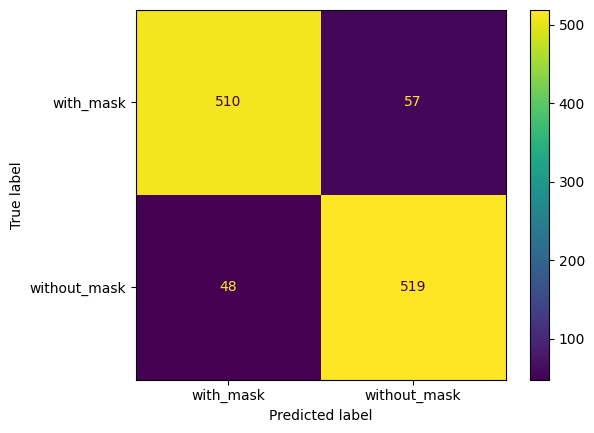

In [120]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.class_to_idx)
disp.plot()

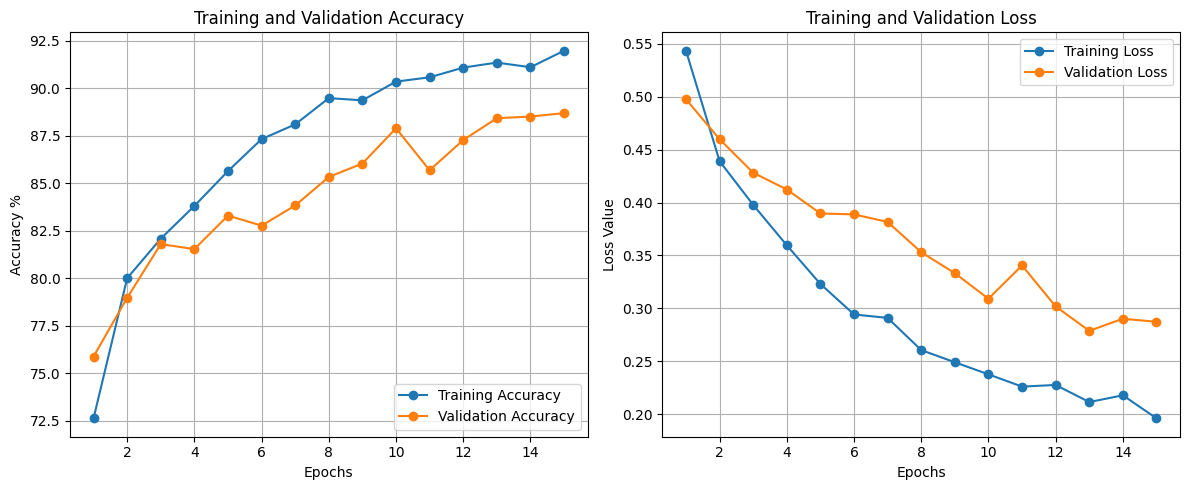

In [116]:
# ploting histories

acc = history_exp1['train_accuracy']
val_acc = history_exp1['val_accuracy']
loss = history_exp1['train_loss']
val_loss = history_exp1['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range , acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range , val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [121]:
# evaluating 
model.load_state_dict(torch.load('best_model.pth', map_location='cpu'))
model.eval()

test_correct = 0
test_total = 0
y_true = []
y_pred = []

# 2. Run the Test Loop
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        # Track Accuracy
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        # Track for Confusion Matrix
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

final_test_acc = 100 * test_correct / test_total
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Final Test Accuracy: 90.74%
